# Huggingface LLaMA with FSDP
In this notebook we provide a simple exmple of using scalax sjit for FSDP. We train a simple LLaMA transformer model defined in the huggingface transformers library using huggingface datasets. We show that all of these can be done rather easily without modifying the model definition and the tran step function.

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
from flax.training.train_state import TrainState
import optax

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange

from transformers import FlaxLlamaForCausalLM, LlamaConfig, LlamaTokenizer
from datasets import load_dataset

from scalax.sharding import PartitionSpec, MeshShardingHelper, FSDPShardingRule

%matplotlib inline

/nfs/nest/mambaforge/envs/scalax/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## C4 DataLoader
We use the C4 dataset implemented in the Huggingface datasets library. We create a very simple data loader that tokenizes the text and apply sequnce packing to form batches.

In [2]:
def c4_data_loader(batch_size, seq_length):
    chunk_size = batch_size * seq_length
    # Stream the c4 dataset without downloading
    dataset = load_dataset('allenai/c4', 'en', split='train', streaming=True, trust_remote_code=True)
    # Use the free OpenLLaMA tokenizer
    tokenizer = LlamaTokenizer.from_pretrained('openlm-research/open_llama_3b_v2')

    # Use a static mask and position ids here for simplicity
    attention_mask = np.ones((batch_size, seq_length), dtype=np.int32)
    position_ids = np.arange(seq_length, dtype=np.int32).reshape(1, -1)
    position_ids = np.broadcast_to(position_ids, (batch_size, seq_length))
    
    token_buffer = []
    for example in dataset:
        # Sequence packing
        token_buffer.extend(tokenizer.encode(example['text']))
        token_buffer.append(tokenizer.eos_token_id)
        while len(token_buffer) > chunk_size + 1:
            batch = {
                'input_tokens': np.array(
                    token_buffer[:chunk_size], dtype=np.int32
                ).reshape(batch_size, seq_length),  # Input tokens to language model
                'target_tokens': np.array(
                    token_buffer[1:chunk_size + 1], dtype=np.int32
                ).reshape(batch_size, seq_length),  # Shift-by-one training target tokens
                'attention_mask': attention_mask,
                'position_ids': position_ids,
            }
            token_buffer = token_buffer[chunk_size:]
            yield batch        
    

## Sharded Initialization and TrainStep
We define the initialization and train step functions and shard them with the `sjit` method of `MeshShardingHelper` to implement FSDP. In FSDP, the model and data are sharded along the same FSDP axis. For data, we can just specify the sharding for the batch axis. For model, we use the builtin `FSDPShardingRule` to find a good FSDP axis for us automatically. All of these can be simply specified as arugments to `sjit`, without changing the `init_fn` and `train_step` functions. The `init_fn` and `train_step` functions here are exactly the same as if we are training on a single GPU.

In [3]:
# Define a 1D mesh with a `fsdp` axis only
mesh = MeshShardingHelper([-1], ['fsdp'])
# Use FSDP sharding rule with axis name `fsdp`
model_sharding_rule = FSDPShardingRule(fsdp_axis_name='fsdp')

# A super small llama model with only 3 layers for demo
config = LlamaConfig(
    num_hidden_layers=3,
    hidden_size=1024,
    intermediate_size=2048,
    num_attention_heads=4,
)
model = FlaxLlamaForCausalLM.module_class(config=config)
seq_length = 512
optimizer = optax.adamw(0.001)


@partial(
    mesh.sjit,  # Shard the initialization function
    out_shardings=model_sharding_rule,  # The initialized model and optimizer states should be sharded by FSDP
)
def init_fn(rng):
    params = model.init(
        input_ids=jnp.zeros((4, seq_length), dtype=jnp.int32),
        position_ids=jnp.zeros((4, seq_length), dtype=jnp.int32),
        attention_mask=jnp.ones((4, seq_length), dtype=jnp.int32),
        rngs={'params': rng},
    )
    return TrainState.create(params=params, tx=optimizer, apply_fn=None)


@partial(
    mesh.sjit,  # Shard the train step function
    # The input model should be sharded with FSDP, the data is loaded as replicated
    in_shardings=(model_sharding_rule, PartitionSpec()),
    # The output model should be sharded with FSDP, the loss metrics is replicated
    out_shardings=(model_sharding_rule, PartitionSpec()),
    # After the beginning of the function, the data should be sharded along the `fsdp` axis
    args_sharding_constraint=(model_sharding_rule, PartitionSpec('fsdp')),
    donate_argnums=(0,),  # No need to preserve the old model
)
def train_step(train_state, batch):
    def loss_fn(params):
        logits = model.apply(
            params,
            input_ids=batch['input_tokens'],
            attention_mask=batch['attention_mask'],
            position_ids=batch['position_ids'],
        ).logits
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits, batch['target_tokens']
        )
        return jnp.mean(loss)
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, loss
    

## Running the Sharded Train Step
Now let's run the sharded train step for 100 steps and plot the loss

  0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Token indices sequence length is longer than the specified maximum sequence length for this model (2637 > 2048). Running this sequence through the model will result in indexing errors



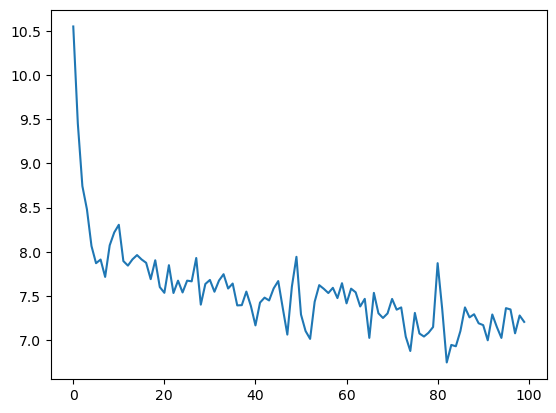

In [4]:
data_iterator = c4_data_loader(8, seq_length)
train_state = init_fn(jax.random.PRNGKey(42))

losses = []
for _, batch in zip(trange(100), data_iterator):
    train_state, loss = train_step(train_state, batch)
    losses.append(loss)

plt.plot(losses)